# OFC-2 Data Example

Data is freely available and described in detail here: https://crcns.org/data-sets/ofc/ofc-2

I wrote some (somewhat ugly) code to collect the data into a nice format, see `OFC-2-wrangle-data.ipynb`.

The time warping code works nicely when the data are organized as follows:

* Precise spike times are encoded by three 1d arrays: `trials`, `times`, `neurons`. The arrays are the same length, and hold the number of spikes in the dataset:
```python
len(trials) == len(times) == len(neurons) = # total number of spikes in the dataset
```
* For the `i`-th spike in the data:
```python
times[i] = # decimal number between 0 and 1, the time of the spike within the trial
neurons[i] = # integer number, the index of the neuron that fired the spike
trials[i] = # integer number, the trial that the i-th spike was fired on
```
* The time warping is fit on binned spike counts but the warping functions are applied to the raw spike times. Here, the binned spike counts were pre-computed and are held in the variable `binned`.
```python
binned = # n_trials x n_timebins x n_neurons, holding spike counts in each bin
```
* Note that the timebins should be linearly spaced within each trial.
* In this notebook we fit the warping functions to the neural data, but then apply those warping functions to behavioral events which are held in `metadata`. Specifically, we will plot the timing of reward onset in clock time and after warping as red dots on raster plots. `metadata['water_on']` is a 1d array holding the time (normalized to range from zero to one) of water onset for each trial.
```python
len(metadata['water_on']) = # n_trials
```

The model is implemented in the `AffineWarping` class, which has an API inspired by the [`scikit-learn`](http://scikit-learn.org/) library. The basic procedure is:
```python
from affinewarp import AffineWarping
model = AffineWarping()
model.fit(binned)
warped_spiketimes = model.transform_events(trials, times)
```
There are some customizable options in the `AffineWarping` class:
* `n_knots` : integer number of discontinuities in the warping function (`n_knots = 0` gives linear warpings).
* `l2_smoothness` : nonnegative decimal number penalizing the trial-average template learned by the model.

In [1]:
# See OFC-2-wrangle-data.ipynb for procedure to download and pre-process data #

# load data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import deepdish as dd
ofc2 = dd.io.load('ofc2_data.h5')

# spike times 
trials = ofc2['trials']
times = ofc2['times']
neurons = ofc2['neurons']

# binned spike data (trials x time x neurons array)
binned = ofc2['binned']

# dict holding trials specific data
#    - metadata['water_on'] gives the time that the reward water turned on each trial
metadata = ofc2['metadata']

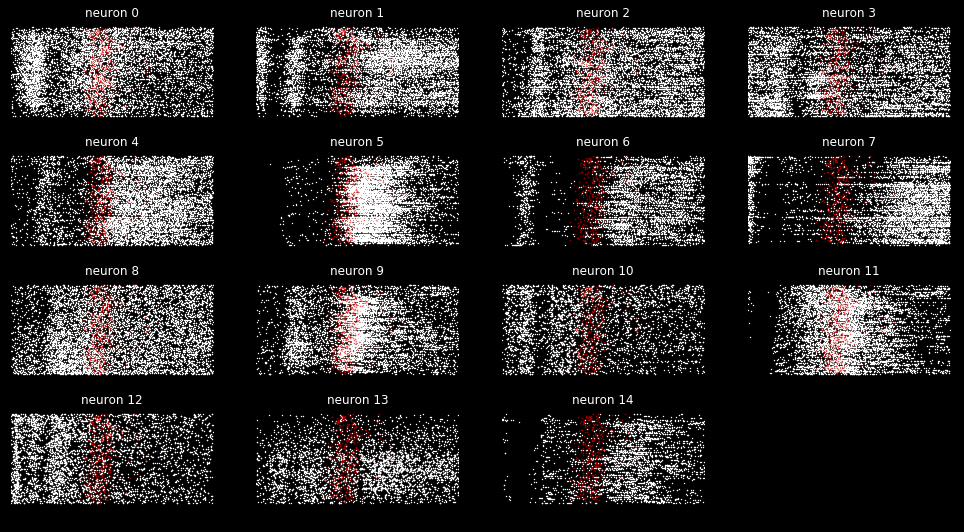

In [2]:
from affinewarp.visualization import rasters

fig, axes = rasters(trials, times, neurons, subplots=(4, 4), s=2);
for ax in axes.ravel()[:-1]:
    ax.scatter(metadata['water_on'], np.unique(trials), c='r', s=.5, alpha=.5)
    ax.set_xlim([0, 1])

Loss improvement: 0.01%: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


Text(0,0.5,'reconstruction error')

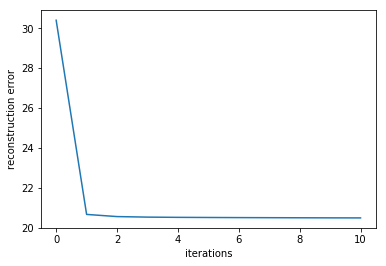

In [3]:
# specify model
from affinewarp import AffineWarping
model = AffineWarping(n_knots=0)

# fit model and show loss history
model.fit(binned, iterations=10, warp_iterations=20)
plt.plot(model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('reconstruction error')

/Users/alex/code/affinewarp/affinewarp/interp.py:29: RuntimeWarning: invalid value encountered in greater
  p = np.argmin(xtst[:, None] > X, axis=1)
/Users/alex/code/affinewarp/affinewarp/interp.py:49: RuntimeWarning: invalid value encountered in greater
  idx = lam > 1
/Users/alex/code/affinewarp/affinewarp/interp.py:51: RuntimeWarning: invalid value encountered in less
  idx = lam < 0


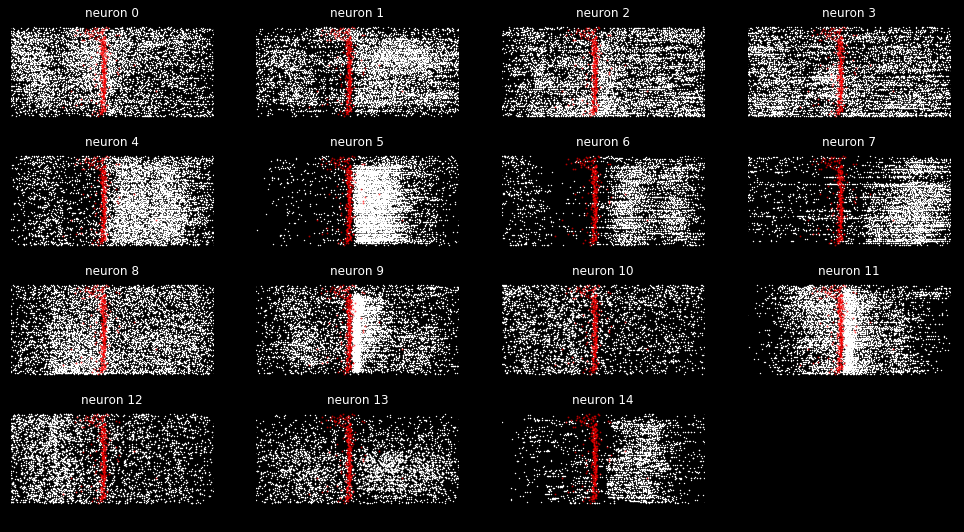

In [4]:
# warp each spike
warped_spiketimes = model.transform_events(trials, times)

# warp the onset of reward for each trial
warped_water_on = model.transform_events(np.unique(trials), metadata['water_on'])

# plot rasters
fig, axes = rasters(trials, warped_spiketimes, neurons, subplots=(4, 4), s=2);
K = len(binned)
for ax in axes.ravel()[:-1]:
    ax.scatter(warped_water_on, np.unique(trials), c='r', s=1, alpha=.5)
    ax.set_xlim([0, 1])